# Difc calculation using scipy

This notebook was improved several times
* In Si-difc-2-D23 we did pretty simple gaussian fit to just one peak
* In Si-difc-2-B9 we found we need more peaks because at different places the d-range is different. Also we add a background to fitting function. And we make better guess
* In Si-difc-2-B3 we found another bug. Sometimes when the peak has no data (all zeros) the "fitting" was successful. Modify to mask those cases.

In [1]:
import matplotlib
%matplotlib notebook
import matplotlib.pyplot as plt

In [2]:
import os, numpy as np
from mantid import simpleapi as msa, mtd

In [3]:
dvalues = [1.10860231, 1.24596143, 1.357755, 1.63751414, 1.92015553, 3.13560085]

In [5]:
%%time
ws = msa.Load('/SNS/SEQ/IPTS-19573/nexus/SEQ_130273.nxs.h5')

CPU times: user 55.2 s, sys: 20.7 s, total: 1min 15s
Wall time: 3min 33s


In [6]:
%%time
ws = msa.CropWorkspace(InputWorkspace=ws, XMin=300, XMax=16666.7)

CPU times: user 3min 44s, sys: 3min, total: 6min 44s
Wall time: 25.9 s


## Compute nominal difc

In [7]:
difc = msa.CalculateDIFC(InputWorkspace=ws)

In [8]:
difc = difc.extractY().flatten()

# Use nominal values to convert to I(d)

In [9]:
%%time
I_d = msa.ConvertUnits(InputWorkspace=ws, Target='dSpacing', EMode='Elastic')

CPU times: user 11.1 s, sys: 9.53 s, total: 20.6 s
Wall time: 20.6 s


In [10]:
%%time
I_d = msa.Rebin(InputWorkspace=I_d, Params='0.4,0.005,7')

CPU times: user 60 ms, sys: 12 ms, total: 72 ms
Wall time: 70.4 ms


# det IDs

In [11]:
N = ws.getNumberHistograms()

In [12]:
detIDs = []
for i in range(N):
    sp = ws.getSpectrum(i)
    did = list(sp.getDetectorIDs())
    assert len(did) == 1
    detIDs.append(did[0])
    continue

In [13]:
detIDs = np.array(detIDs)

In [78]:
np.save('./difc-2-detID.npy', detIDs)

## Fitting gadgets

In [14]:
import scipy.optimize as sopt

In [15]:
def gauss(x, *p):
    A, mu, sigma = p
    return A*np.exp(-(x-mu)**2/(2.*sigma**2))

In [16]:
def gauss_with_bg(x, *p):
    A, mu, sigma, bg = p
    return bg + A*np.exp(-(x-mu)**2/(2.*sigma**2))

## Loop over all pixels

In [17]:
N = I_d.getNumberHistograms()

In [18]:
maxchisq = 3.
min_counts = 200 # at least this many counts per peak

In [24]:
newdifc = difc.copy()
mask = np.zeros(difc.shape, dtype=bool)
chisq = np.zeros((len(dvalues),) + difc.shape, dtype=float)
peaks = np.zeros((len(dvalues),) + difc.shape, dtype=float)

In [20]:
def fit_pixel(x, y, dvalues, peaks_thispixel=None, chisq_thispixel=None):
    if peaks_thispixel is None:
        peaks_thispixel = np.zeros(len(dvalues), dtype=float)
    if chisq_thispixel is None:
        chisq_thispixel = np.zeros(len(dvalues), dtype=float)
    for pkindex, d0 in enumerate(dvalues):
        dmin = d0*.96
        dmax = d0*1.04
        startindex, stopindex = np.where(x>dmin)[0][0], np.where(x<dmax)[0][-1]
        x1 = x[startindex:stopindex]
        y1 = y[startindex:stopindex]
        # print x1
        # print y1
        guess_center = x1[np.argmax(y1)]
        startindex, stopindex = np.where(x>guess_center-0.05*d0)[0][0], np.where(x<guess_center+0.05*d0)[0][-1]
        x1 = x[startindex:stopindex]
        y1 = y[startindex:stopindex]
        if np.sum(y1) < min_counts:
            peaks_thispixel[pkindex] = np.nan
            continue
        bg = (y1[0]+y1[-1])/2
        p0 = np.max(y1)-bg, guess_center, 0.01, bg
        # print "p0=",p0
        # print x1
        # print y1
        try:
            popt, pcov = sopt.curve_fit(gauss_with_bg, x1, y1, p0=p0)
        except:
            peaks_thispixel[pkindex] = np.nan
            continue
        # print "popt=", popt
        chisq1 = np.average((y1 - gauss_with_bg(x1, *popt))**2 / (y1+.1))
        chisq_thispixel[pkindex] = chisq1
        # print "chisq=", chisq1
        if chisq1 > maxchisq:
            peaks_thispixel[pkindex] = np.nan
            continue
        peaks_thispixel[pkindex] = popt[1]
        continue
    return peaks_thispixel

In [25]:
%%time
# for pixel in range(firstindex, lastindex+1):
# for pixel in range(firstindex+50, firstindex+51):
# for pixel in range(8240, 8250):
# for pixel in range(2108, 2109):
for pixel in range(N):
    if (pixel%1000)==0 : print pixel
    # print pixel
    I_d_pixel = msa.SumSpectra(InputWorkspace=I_d, StartWorkspaceIndex=pixel, EndWorkspaceIndex=pixel)
    Xbb = I_d_pixel.readX(0)
    x = (Xbb[:-1]+Xbb[1:])/2
    y = I_d_pixel.readY(0)
    peaks_thispixel = peaks[:, pixel]
    chisq_thispixel = chisq[:, pixel]
    fit_pixel(x,y, dvalues, peaks_thispixel, chisq_thispixel)
    Ngoodfit = np.sum(np.isfinite(peaks_thispixel))
    # print Ngoodfit
    if not Ngoodfit:
        mask[pixel] = 1
        continue
    ratios = peaks_thispixel / dvalues
    # print "ratios=", ratios
    good_ratios = ratios[np.isfinite(ratios)]
    # print "good_ratios=", good_ratios
    average_ratio = np.average(good_ratios)
    newdifc[pixel] = difc[pixel] * average_ratio
    # print average_ratio
    # break
    continue

0
1000
2000
3000
4000


/home/lj7/miniconda2/envs/mantid/lib/python2.7/site-packages/scipy/optimize/minpack.py:779: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
78000
79000
80000
81000
82000
83000
84000
85000
86000
87000
88000
89000
90000
91000
92000
93000
94000
95000
96000
97000
98000
99000
100000
101000
102000
103000
104000
105000
106000
107000
108000
109000
110000
111000
112000
113000
114000
115000
CPU times: user 27min 52s, sys: 7min 14s, total: 35min 6s
Wall time: 27min 3s


In [26]:
np.sum(mask)

20523

In [27]:
# number of masked pixels per pack
mask1 = mask.copy()
mask1.shape = -1, 1024

masks_per_pack = np.sum(mask1, axis=-1)

masks_per_pack

array([1024, 1024,   77,   48,   51,   41,   46,   49,   49,   45,   56,
         44,   52,   40,   61,   50,   45,   52, 1024,   55,   47,   70,
        119,  105,  123,  121,   96,   55,   55,   48,   51,   51,   51,
         48,   50,   56,   52, 1024, 1024,   55,   48,   48,   47,   49,
         55,   55,   53,   54,   45,   49,   51,   59,   40,   51,   52,
         47,   78,  202,  443,  575,  756, 1024, 1024,  946,  996,  807,
        539,  374,  118,   54,   51,   56,   56,   52,   45,   56, 1024,
       1024,   70,   44,   50,   51,   44,   53,   56,   53,   51,   47,
         52,   49,   42,   46,   47,   51,   55,   53,   55,   76,  106,
        114,  130,  126,  109,   80,   64,   52,   51,   45,   55,   57,
         54,   44,   54])

In [28]:
# check chisq for some pixels. Each row is for one pixel. Cols are peaks
chisq[:, 8240:8245].T

array([[ 2.27164662,  0.77428236,  1.02849932,  1.63507325,  0.        ,
         0.        ],
       [ 0.65846035,  1.00940032,  0.76778776,  0.96183364,  0.        ,
         0.        ],
       [ 1.14335795,  1.24741144,  1.09638629,  1.74700102,  0.        ,
         0.        ],
       [ 0.93783347,  1.03429387,  1.47315641,  1.35813717,  0.        ,
         0.        ],
       [ 1.2293001 ,  1.36842902,  0.54415248,  2.55600124,  0.        ,
         0.        ]])

# Save

In [29]:
np.save('./difc-2-difc.npy', newdifc)
np.save('./difc-2-mask.npy', mask)

# * Old - Check pack 58 - found a bug
Here we notice a bug. The chisq could be inf if some of the bins have zero intensity

In [38]:
mask_pack58 = mask1[58]
mask_pack58.shape = 8,128
mask_pack58

array([[False, False,  True, ...,  True, False, False],
       [False, False,  True, ..., False, False, False],
       [False, False,  True, ..., False, False, False],
       ..., 
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]], dtype=bool)

In [40]:
mask_pack58[0]

array([False, False,  True,  True, False, False, False,  True, False,
       False, False,  True, False, False,  True,  True, False,  True,
        True,  True,  True, False,  True,  True,  True,  True,  True,
        True,  True, False,  True, False,  True,  True,  True,  True,
        True,  True, False,  True, False,  True,  True,  True,  True,
        True,  True,  True,  True,  True, False,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True, False,  True,
        True,  True,  True,  True,  True,  True, False,  True,  True,
        True, False,  True, False, False,  True,  True,  True,  True,
        True,  True, False, False, False, False,  True,  True,  True,
        True, False, False,  True,  True,  True,  True,  True,  True,
       False, False]

In [42]:
pixelindex= 58*1024+0*128+60
print pixelindex

59452


In [43]:
I_d_59452 = msa.SumSpectra(InputWorkspace=I_d, StartWorkspaceIndex=59452, EndWorkspaceIndex=59452)

<IPython.core.display.Javascript object>


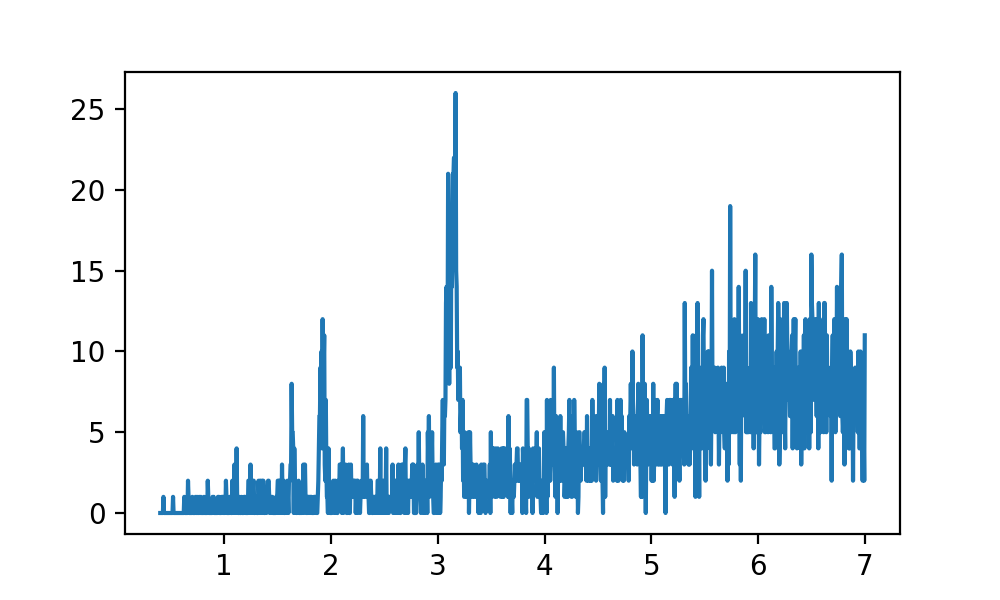

In [47]:
plt.figure(figsize=(5,3))
Xbb = I_d_59452.readX(0)
x,y = (Xbb[:-1]+Xbb[1:])/2, I_d_59452.readY(0)
plt.plot( x,y)
# plt.xlim(3,3.35)

In [54]:
def fit_pixel(x, y):
    peaks_thispixel = np.zeros(len(dvalues), dtype=float)
    for pkindex, d0 in enumerate(dvalues):
        dmin = d0*.96
        dmax = d0*1.04
        startindex, stopindex = np.where(x>dmin)[0][0], np.where(x<dmax)[0][-1]
        x1 = x[startindex:stopindex]
        y1 = y[startindex:stopindex]
        # print x1
        # print y1
        guess_center = x1[np.argmax(y1)]
        startindex, stopindex = np.where(x>guess_center-0.05*d0)[0][0], np.where(x<guess_center+0.05*d0)[0][-1]
        x1 = x[startindex:stopindex]
        y1 = y[startindex:stopindex]
        bg = (y1[0]+y1[-1])/2
        p0 = np.max(y1)-bg, guess_center, 0.01, bg
        print "p0=",p0
        print x1
        print y1
        try:
            popt, pcov = sopt.curve_fit(gauss_with_bg, x1, y1, p0=p0)
        except:
            peaks_thispixel[pkindex] = np.nan
            continue
        print "popt=", popt
        chisq1 = np.average((y1 - gauss_with_bg(x1, *popt))**2 / (y1+.1))
        # chisq[pkindex, pixel] = chisq1
        print "chisq=", chisq1
        if chisq1 > maxchisq:
            peaks_thispixel[pkindex] = np.nan
            continue
        peaks_thispixel[pkindex] = popt[1]
        continue
    return peaks_thispixel


In [55]:
fit_pixel(x,y)

p0= (3.5, 1.1174999999999979, 0.01, 0.5)
[ 1.0625  1.0675  1.0725  1.0775  1.0825  1.0875  1.0925  1.0975  1.1025
  1.1075  1.1125  1.1175  1.1225  1.1275  1.1325  1.1375  1.1425  1.1475
  1.1525  1.1575  1.1625  1.1675]
[ 1.  0.  0.  2.  0.  1.  0.  3.  0.  2.  0.  4.  1.  1.  0.  0.  1.  0.
  0.  0.  1.  0.]
popt= [  1.23808416e+01   1.11940139e+00   1.18261526e-03   6.00000100e-01]
chisq= 2.16600107268
p0= (2.0, 1.2474999999999952, 0.01, 1.0)
[ 1.1875  1.1925  1.1975  1.2025  1.2075  1.2125  1.2175  1.2225  1.2275
  1.2325  1.2375  1.2425  1.2475  1.2525  1.2575  1.2625  1.2675  1.2725
  1.2775  1.2825  1.2875  1.2925  1.2975  1.3025]
[ 1.  1.  1.  0.  0.  0.  0.  0.  2.  2.  2.  0.  3.  1.  1.  0.  1.  2.
  2.  0.  0.  1.  0.  1.]
popt= [ 1.17259717  1.24015502  0.01028249  0.62315108]
chisq= 3.22322275956
p0= (1.5, 1.3224999999999936, 0.01, 0.5)
[ 1.2575  1.2625  1.2675  1.2725  1.2775  1.2825  1.2875  1.2925  1.2975
  1.3025  1.3075  1.3125  1.3175  1.3225  1.3275  1.3325  1.3375

array([ 1.11940139,         nan,  1.34      ,         nan,  1.92011497,
        3.14072268])

# Check aligned I(d)

In [30]:
t = msa.Load('./difc_cal.nxs')

In [31]:
t.getColumnNames()

['detid', 'difc', 'difa', 'tzero', 'tofmin', 'tofmax']

In [32]:
tzero = np.array(t.column('tzero'))

In [33]:
np.all(tzero==0)

True

In [34]:
for i, v in enumerate(newdifc):
    t.setCell('difc', i, v)
    continue

In [35]:
%%time
aligned = msa.AlignDetectors(InputWorkspace=ws, CalibrationWorkspace=t)

CPU times: user 31.9 s, sys: 35.8 s, total: 1min 7s
Wall time: 21.4 s


In [40]:
%%time
aligned = msa.CropWorkspace(InputWorkspace='aligned', XMin=0.4, XMax=7)

CPU times: user 43 s, sys: 39.2 s, total: 1min 22s
Wall time: 6.18 s


In [36]:
%%time
I_d_new = msa.Rebin(InputWorkspace=aligned, Params='0.4,0.0005,7')

CPU times: user 4.55 s, sys: 7.8 s, total: 12.3 s
Wall time: 12.3 s


In [37]:
I_d_new_all = msa.SumSpectra(InputWorkspace=I_d_new)

In [38]:
I_d_all = msa.SumSpectra(InputWorkspace=I_d)

In [ ]:
x_bb = I_d_all.readX(0); y = I_d_all.readY(0)
x = (x_bb[1:] + x_bb[:-1])/2

new_x_bb = I_d_new_all.readX(0); new_y = I_d_new_all.readY(0)
new_x = (new_x_bb[1:] + new_x_bb[:-1])/2

<IPython.core.display.Javascript object>


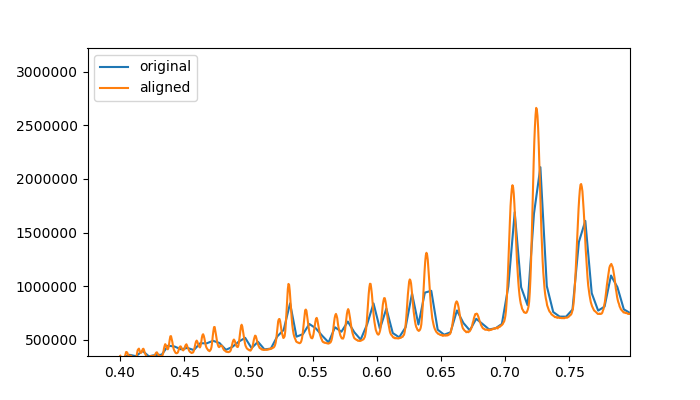

In [40]:
plt.figure(figsize=(7,4))
plt.plot(x,y, label='original')
plt.plot(new_x,new_y*10, label='aligned')

plt.xlim(0,3.8)
plt.legend(loc='upper left')

** This is partially due to a smaller bin size **

<IPython.core.display.Javascript object>


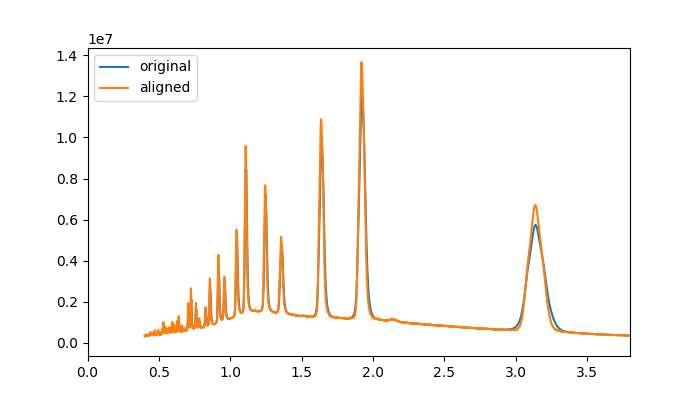

In [41]:
plt.figure(figsize=(7,4))
plt.plot(x,y, label='original')
plt.plot(new_x,new_y*10, label='aligned')

plt.xlim(0,3.8)
plt.legend(loc='upper left')

<IPython.core.display.Javascript object>


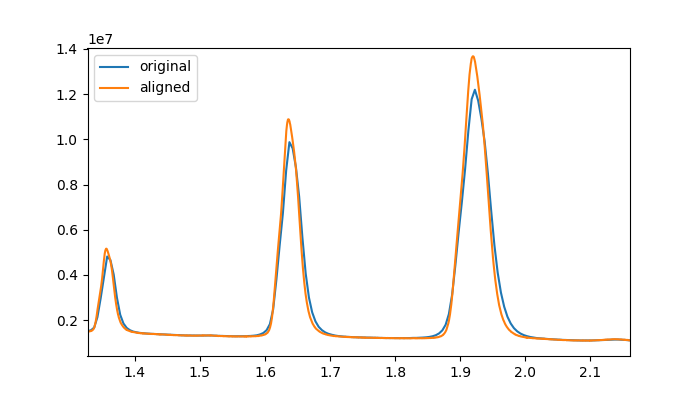

In [42]:
plt.figure(figsize=(7,4))
plt.plot(x,y, label='original')
plt.plot(new_x,new_y*10, label='aligned')

plt.xlim(0,3.8)
plt.legend(loc='upper left')

## * Obsolete

In [46]:
I_d_pack_d23 = msa.SumSpectra(InputWorkspace=I_d_new, StartWorkspaceIndex=100352, EndWorkspaceIndex=101375)

<IPython.core.display.Javascript object>


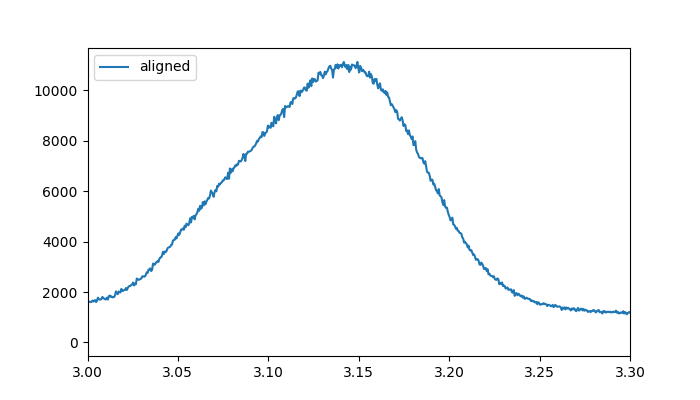

In [47]:
x_bb = I_d_pack_d23.readX(0); y = I_d_pack_d23.readY(0)
x = (x_bb[1:] + x_bb[:-1])/2
plt.figure(figsize=(7,4))
plt.plot(x,y, label='aligned')
plt.xlim(3,3.3)
plt.legend(loc='upper left')

In [49]:
I_d_100455 = msa.SumSpectra(InputWorkspace=I_d_new, StartWorkspaceIndex=100455, EndWorkspaceIndex=100455)

<IPython.core.display.Javascript object>


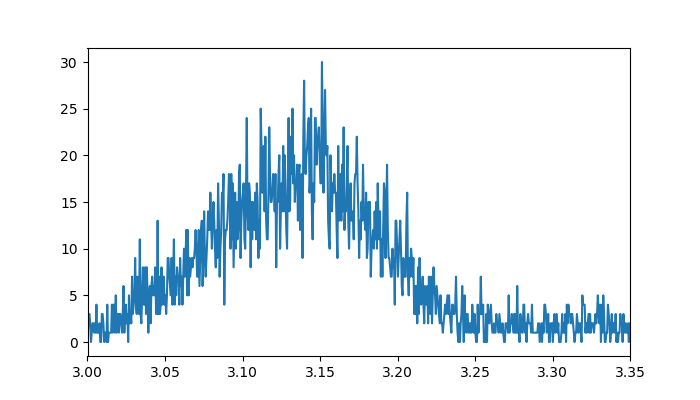

(3, 3.35)

In [50]:
plt.figure(figsize=(7,4))
Xbb = I_d_100455.readX(0)
plt.plot( (Xbb[:-1]+Xbb[1:])/2, I_d_100455.readY(0))
plt.xlim(3,3.35)